# Generation of an unimodal prognosis predictor 
### Sub-title: A script to generate unimodal prognosis predictor for 3D medical image data
#### Description: 일반암의 3D 진단영상 데이터를 대상으로 예후 예측 모델을 구축하는 파이썬 스크립트 코드 입니다. 

### Step 1. Loading packages
>#### Description: 훈련 과정에서 필요한 패키지 전반을 로딩합니다. 아래 코드를 CTRL + Enter로 실행하십시오. 패키지가 설치되어 있지 않으면 conda install 또는 pip install 명령으로 설치하시기 바랍니다.

In [1]:
#import dependencies
import pandas as pd
import nibabel as nib
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from matplotlib import pyplot

### Step 2. Loading meta data
>#### Description: 예측모델 훈련 및 검증에 사용할 파일리스트 목록을 로딩합니다. 파일 리스트 목록이 저장된 파일은 텍스트 형식입니다. 아래 코드에서 파일명 및 경로를 지정하십시오.
>#### 파일 리스트 목록의 컬럼양식은 다음과 같습니다:
>*[순서번호, 환자ID, nii파일이름, nii파일이_저장된_root경로, 생존여부(3년_또는_5년기준)]*
>#### 자세한 형식은 동봉된 예제 데이터의 양식("UC_005.nii_3yr_meta.unimodal.txt")을 참조하시기 바랍니다.

In [3]:
# load meta data
meta_filename = "UC_005.nii_3yr_meta.unimodal.txt"

bcrDataFrame = pd.read_csv(meta_filename, sep="\t", index_col=0)

column_header_list = list(bcrDataFrame.columns)

patient_list = list(bcrDataFrame[column_header_list[0]])
nii_list = list(bcrDataFrame[column_header_list[1]])
data_root_folder = list(bcrDataFrame[column_header_list[2]])
dfs_3yr_list = list(bcrDataFrame[column_header_list[3]])

print("#n of nii files: " + str(len(nii_list)))

#n of nii files: 703


### Step 3. Loading nifti-formatted image files
>#### Description: 메타데이터 목록에서 지정되어 있는 nifti 형식의 3D 이미지를 읽어 numpy array 형식으로 저장합니다.아래 코드에서 저장하고자 하는 numpy array 파일명(변수: nparrays_filename)을 지정하고, CTRL + Enter로 실행하십시오.

In [5]:
# load nii files
nparrays_filename = "nparrays_of_niis.npy"
samples_files = []
for i in range(len(nii_list)):
    samples_files.append(data_root_folder[i] + "/"  + nii_list[i])

image_nparrays = []
for i in range(len(samples_files)):
    img = nib.load(samples_files[i]).get_fdata()
    img /= np.max(img)
    nparray = np.array(img, dtype=np.float32)
    x = nparray.shape[0]
    y = nparray.shape[1]
    z = nparray.shape[2]
    converted_array = nparray.reshape((x,y,z))
    image_nparrays.append(converted_array)
image_nparrays = np.array(image_nparrays)

# change data type to "np.float32"
image_nparrays = image_nparrays.astype(np.float32)

print("image_nparrays shape is" + str(image_nparrays.shape))

# save numpy arrays
np.save(nparrays_filename,image_nparrays)

image_nparrays shape is(703, 80, 80, 30)


### Step 4. Loading end-point data of prognosis
>#### Description: 메타데이터 목록에 저장된 환자의 예후 데이터를 로딩합니다. 전형적인 예로 3년 생존 또는 5년 생존 여부(0:no_event, 1:event)를 적용할 수 있습니다.
>#### 더불어, 예측모델 훈련 및 검증을 위해, 훈련데이터와 검증데이터를 random으로 분리합니다. 보통 8:2 또는 7:3 비율로 데이터를 분리합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [6]:
#Save prognosis data
prog_data_list = []
for i in range(len(dfs_3yr_list)):
    prog_data_list.append([patient_list[i], dfs_3yr_list[i]])

# load numpy arrays and labels
x_all = np.load(nparrays_filename)

# split into TRAIN and TEST sets
x_train, x_test, prog_train, prog_test = train_test_split(x_all, prog_data_list, test_size=0.2)

print("x_train = ", x_train.shape)
print("x_test = ", x_test.shape)

y_train = []
for prog in prog_train:
    y_train.append(prog[1])

y_test = []
for prog in prog_test:
    y_test.append(prog[1])

# print(y_train)
# print(y_test)

x_train =  (562, 80, 80, 30)
x_test =  (141, 80, 80, 30)


### Step 5. Encode end-point labels into one-hot codes
>#### Description: 예측 대상 예후 데이터를 원-핫 인코딩을 적용합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [7]:
# one-hot encode the labels in train and test datasets
# we use “to_categorical” function in keras 

num_classes = 2  #dfs_3yr: 0 ~ 1
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

# let's display one of the one-hot encoded labels
y_train[0]

array([1., 0.], dtype=float32)

### Step 6. Development of prediction model
>#### Description: 사용자의 입력데이터의 shape를 지정하십시오. 기본으로 (80,80,30)으로 설정되어 있습니다.
>#### 예측모델을 구축합니다. 본 스크립트에서는 높은 예측성능이 검증된 알려진 모델(ResNet152)을 도입합니다. 사용자의 통찰에 따라 여러가지 다른 예측모델을 도입할 수 있습니다 (도입가능 모델: https://keras.io/api/applications/).
>#### 설정이 완료되었으면, 아래 코드를 CTRL + Enter로 실행하십시오.

In [8]:
#setup image shape
img_shape = (80,80,30)

#adopt model
import keras
from tensorflow.keras import applications
model = applications.resnet.ResNet152(weights= None, include_top=True, input_shape= img_shape, classes=num_classes)

model.summary()

/home/master/anaconda3/envs/deepMIMO/lib/python3.11/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 30 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 86, 30)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 40, 64)   94144       ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 40, 64)   256         ['conv1_conv[0][0]']     

 conv2_block3_2_conv (Conv2D)   (None, 20, 20, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 20, 20, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 20, 20, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 20, 20, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 10, 10, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 10, 10, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 10, 10, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 10, 10, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block6_2_relu (Activatio  (None, 10, 10, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 10, 10, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 10, 10, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_add (Add)         (None, 10, 10, 512)  0           ['conv3_block5_out[0][0]',       
                                                                  'conv3_block6_3_bn[0][0]']      
          

 conv4_block1_3_conv (Conv2D)   (None, 5, 5, 1024)   263168      ['conv4_block1_2_relu[0][0]']    
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 5, 5, 1024)  4096        ['conv4_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 5, 5, 1024)  4096        ['conv4_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_add (Add)         (None, 5, 5, 1024)   0           ['conv4_block1_0_bn[0][0]',      
                                                                  'conv4_block1_3_bn[0][0]']      
          

 conv4_block4_3_bn (BatchNormal  (None, 5, 5, 1024)  4096        ['conv4_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_add (Add)         (None, 5, 5, 1024)   0           ['conv4_block3_out[0][0]',       
                                                                  'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 5, 5, 1024)   0           ['conv4_block4_add[0][0]']       
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 5, 5, 256)    262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block7_out (Activation)  (None, 5, 5, 1024)   0           ['conv4_block7_add[0][0]']       
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 5, 5, 256)    262400      ['conv4_block7_out[0][0]']       
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, 5, 5, 256)   1024        ['conv4_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, 5, 5, 256)   0           ['conv4_block8_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block11_1_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 5, 5, 256)    590080      ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block11_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block14_2_conv (Conv2D)  (None, 5, 5, 256)    590080      ['conv4_block14_1_relu[0][0]']   
                                                                                                  
 conv4_block14_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block14_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block14_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block14_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block14_2_relu[0][0]']   
          

                                                                                                  
 conv4_block17_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block17_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block17_2_relu[0][0]']   
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, 5, 5, 1024)  4096        ['conv4_block17_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block17_add (Add)        (None, 5, 5, 1024)   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_3_bn (BatchNorma  (None, 5, 5, 1024)  4096        ['conv4_block20_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_add (Add)        (None, 5, 5, 1024)   0           ['conv4_block19_out[0][0]',      
                                                                  'conv4_block20_3_bn[0][0]']     
                                                                                                  
 conv4_block20_out (Activation)  (None, 5, 5, 1024)  0           ['conv4_block20_add[0][0]']      
                                                                                                  
 conv4_block21_1_conv (Conv2D)  (None, 5, 5, 256)    262400      ['conv4_block20_out[0][0]']      
          

                                                                  'conv4_block23_3_bn[0][0]']     
                                                                                                  
 conv4_block23_out (Activation)  (None, 5, 5, 1024)  0           ['conv4_block23_add[0][0]']      
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 5, 5, 256)    262400      ['conv4_block23_out[0][0]']      
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block24_1_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block24_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block27_1_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block27_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block27_1_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block27_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block27_2_conv (Conv2D)  (None, 5, 5, 256)    590080      ['conv4_block27_1_relu[0][0]']   
                                                                                                  
 conv4_block27_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block27_2_conv[0][0]']   
 lization)

 on)                                                                                              
                                                                                                  
 conv4_block30_2_conv (Conv2D)  (None, 5, 5, 256)    590080      ['conv4_block30_1_relu[0][0]']   
                                                                                                  
 conv4_block30_2_bn (BatchNorma  (None, 5, 5, 256)   1024        ['conv4_block30_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block30_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block30_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 5, 5, 256)   0           ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block33_2_relu[0][0]']   
                                                                                                  
 conv4_block33_3_bn (BatchNorma  (None, 5, 5, 1024)  4096        ['conv4_block33_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block36_3_conv (Conv2D)  (None, 5, 5, 1024)   263168      ['conv4_block36_2_relu[0][0]']   
                                                                                                  
 conv4_block36_3_bn (BatchNorma  (None, 5, 5, 1024)  4096        ['conv4_block36_3_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_add (Add)        (None, 5, 5, 1024)   0           ['conv4_block35_out[0][0]',      
                                                                  'conv4_block36_3_bn[0][0]']     
                                                                                                  
 conv4_block36_out (Activation)  (None, 5, 5, 1024)  0           ['conv4_block36_add[0][0]']      
                                                                                                  
 conv5_blo

 conv5_block3_3_conv (Conv2D)   (None, 3, 3, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 3, 3, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 3, 3, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 3, 3, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 avg_pool 

### Step 7. Training model
>#### Description: 모델을 훈련합니다. 매 훈련 단계마다 검증데이터로 성능을 측정하고 최적값을 모델에 반영합니다. 현재 batch_size=64, epoch=200으로 설정되어 있으며, 훈련 패턴에 따라 사용자가 파라미터를 조정해야 합니다.
>#### 설정이 완료되었으면, 아래 코드를 CTRL + Enter로 실행하십시오.

In [9]:
# training
model_filename = "model.nii_3yr_unimodal.hdf5"
batch_size = 64
epochs=200
#epochs=2

from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

checkpointer = ModelCheckpoint(filepath=model_filename, verbose=1, save_best_only=True)

# you can try any of these optimizers by uncommenting the line
# optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# optimizer = keras.optimizers.adam(lr=0.0005,decay=1e-6)

tf.keras.optimizers.legacy.Adam

#optimizer = optimizers.Adam(lr=0.0001,decay=1e-6)
optimizer = optimizers.legacy.Adam(lr=0.0001,decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, callbacks=[checkpointer],
                batch_size=batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))


Epoch 1/2


/home/master/anaconda3/envs/deepMIMO/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch 1: val_loss improved from inf to 0.58374, saving model to model.nii_3yr_unimodal.hdf5
9/9 - 73s - loss: 0.4169 - accuracy: 0.8452 - val_loss: 0.5837 - val_accuracy: 0.9645 - 73s/epoch - 8s/step
Epoch 2/2

Epoch 2: val_loss improved from 0.58374 to 0.40925, saving model to model.nii_3yr_unimodal.hdf5
9/9 - 53s - loss: 0.2120 - accuracy: 0.9626 - val_loss: 0.4092 - val_accuracy: 0.9645 - 53s/epoch - 6s/step


### Step 8. Estimation of model performance
>#### Description: 훈련이 종료된 후 훈련된 모델(모델의 파일이름 변수:model_filename)을 로딩하고 모델의 성능을 평가합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [10]:
# #load model if needed
from keras.models import load_model
model = load_model(model_filename)

# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=64, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

3/3 [==============================] - 8s 1s/step - loss: 0.4092 - accuracy: 0.9645

Test result: 96.454 loss: 0.409


### Step 9. Plotting the progress during training
>#### Description: 훈련 과정의 성능 그래프를 도시합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

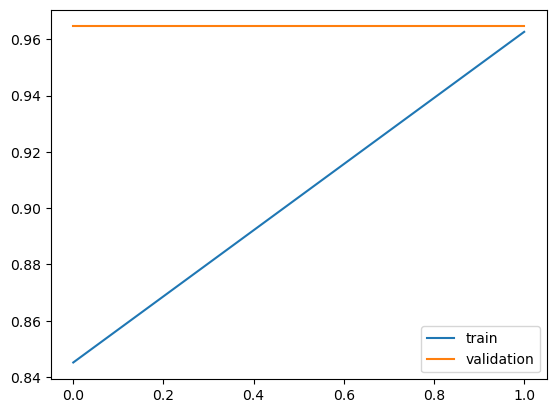

In [11]:
# plot learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()